In [1]:
import joblib
import pandas as pd
import seaborn as sb
import glob
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
data = pd.read_csv("repeatmasker_exact.txt", sep='\t', header=None)
data.columns = ['ref', 'locus', 'count', 'clsfam']
data['repeat'] = data['clsfam'].apply(lambda x: x.split('/')[0])

In [3]:
n_rows = []
for i, d in data.groupby(['ref', 'locus']):
    ref, loc = i
    x = Counter(d["repeat"])
    n_rows.append([ref, loc, len(d), x.most_common()[0][0]])
n_rows = pd.DataFrame(n_rows, columns=['reference', 'locus', 'locus_cnt', 'most_common'])
n_rows['reference'] = n_rows['reference'].apply(lambda x: x.split('/')[1])

most_common
Low_complexity    8.502637
Simple_repeat     6.743722
Retroposon        5.866828
SINE              2.590747
Satellite         2.365347
LINE              2.346618
scRNA             2.176471
LTR               1.703136
DNA               1.369983
Unknown           1.315789
rRNA              1.120000
snRNA             1.000000
srpRNA            1.000000
Name: locus_cnt, dtype: float64

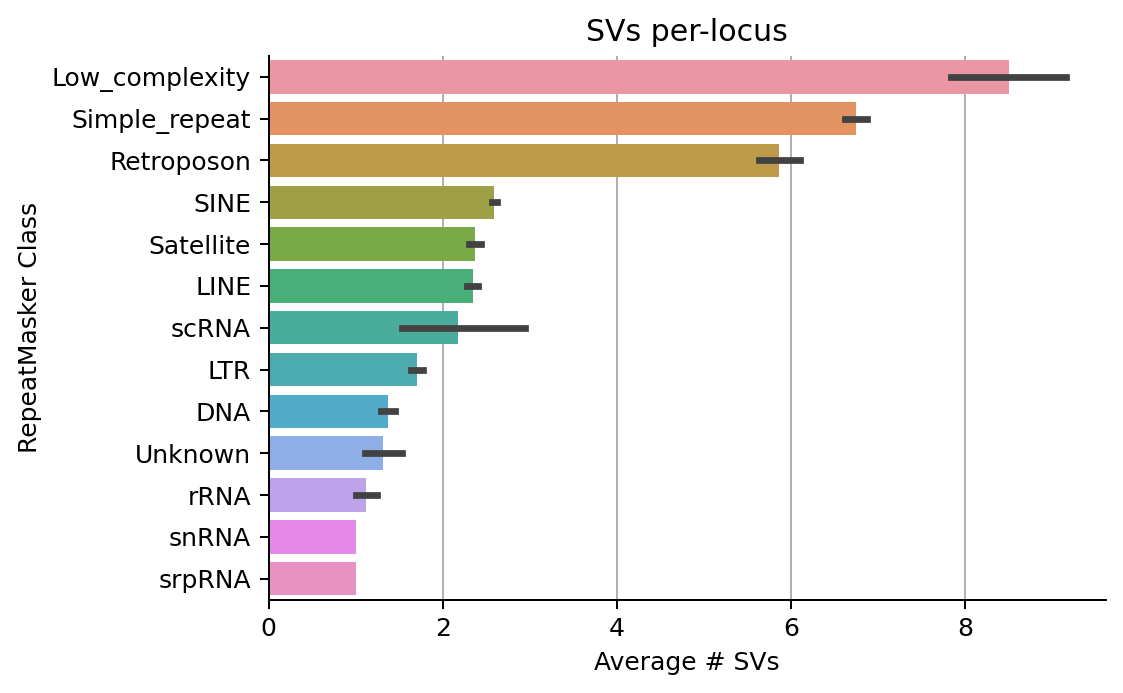

In [5]:
plt.figure(dpi=180)
view = n_rows[n_rows["most_common"] != '.'].groupby(['most_common'])['locus_cnt'].mean()
view = view.sort_values(ascending=False)
p = sb.barplot(data=n_rows[n_rows["most_common"] != '.'], y='most_common', x="locus_cnt", order=view.index)
p.set(title="SVs per-locus", ylabel="RepeatMasker Class", xlabel="Average # SVs")
sb.despine()
plt.grid(which='major', axis='x')
p.set_axisbelow(True)
view

# SVs Per merge

In [47]:
def cat_grid(cat_plot, rotate=False):
    for i, ax1 in enumerate(cat_plot.axes):
        for ax in ax1:
            ax.grid(b=True,which='major',axis='y', linewidth=.8)
            ax.set_axisbelow(True)
            if rotate:
                ax.tick_params('x', labelrotation=90)

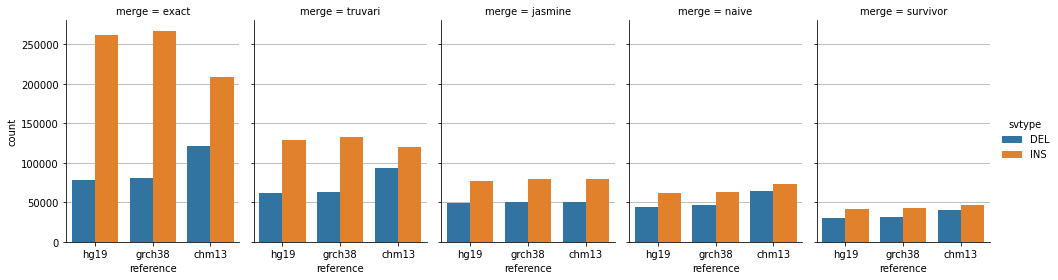

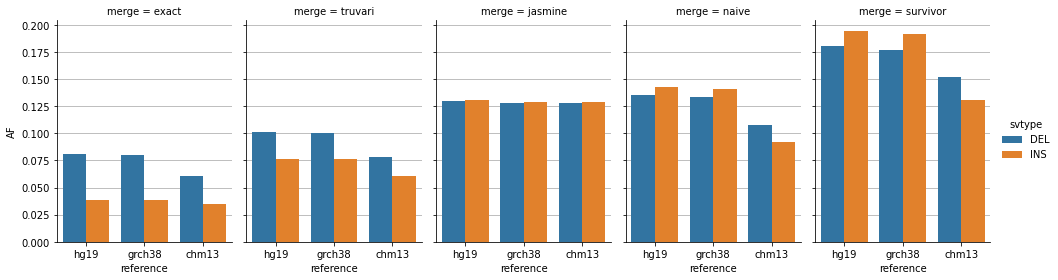

In [22]:
data = pd.read_csv("all_svty_count.txt", sep='\t')
data = data.loc[data["svtype"].isin(['DEL', 'INS'])]
p = sb.catplot(kind='bar', data=data, 
               x="reference", 
               y="count", 
               hue="svtype", 
               col='merge', 
               order=['hg19', 'grch38', 'chm13'],
               hue_order=['DEL', "INS"],
               col_order=['exact', 'truvari', 'jasmine', 'naive', 'survivor'],
               height=4, aspect=.7)
cat_grid(p)
plt.show()

data = pd.read_csv("all_af_dist.txt", sep='\t')
data = data.loc[data["svtype"].isin(['DEL', 'INS'])]
p = sb.catplot(kind='bar', data=data, 
               x="reference", 
               y="AF", 
               hue="svtype", 
               col='merge', 
               order=['hg19', 'grch38', 'chm13'],
               hue_order=['DEL', "INS"],
               col_order=['exact', 'truvari', 'jasmine', 'naive', 'survivor'],
               height=4, aspect=.7)
cat_grid(p)
plt.show()

In [32]:
data = pd.read_csv("all_sz_dist.txt", sep='\t')
data = data.loc[data["svtype"].isin(['DEL', 'INS']) & (data["szbin"] != "[0,50)")]

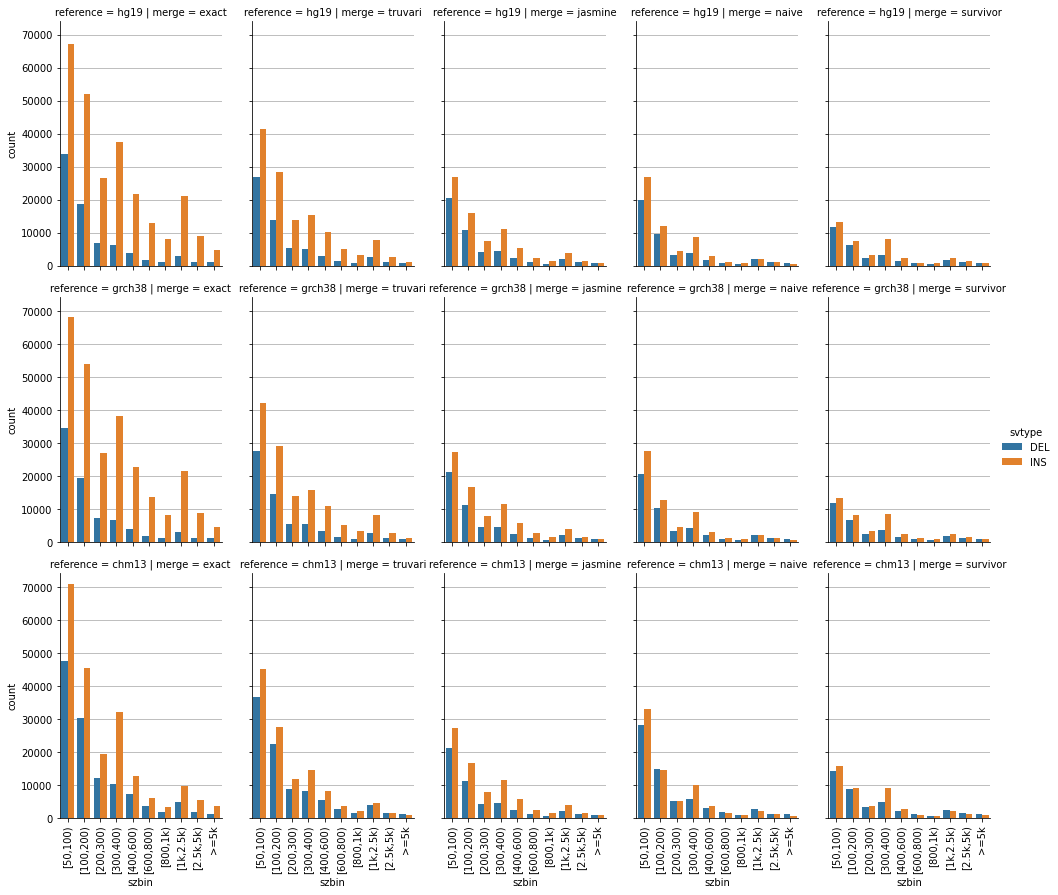

In [48]:
p = sb.catplot(kind='bar', data=data, 
               x="szbin", 
               y="count", 
               hue="svtype", 
               col='merge', 
               row="reference",
               row_order=['hg19', 'grch38', 'chm13'],
               hue_order=['DEL', "INS"],
               col_order=['exact', 'truvari', 'jasmine', 'naive', 'survivor'],
               height=4, aspect=.7)
cat_grid(p, True)
plt.show()

# Figure 3

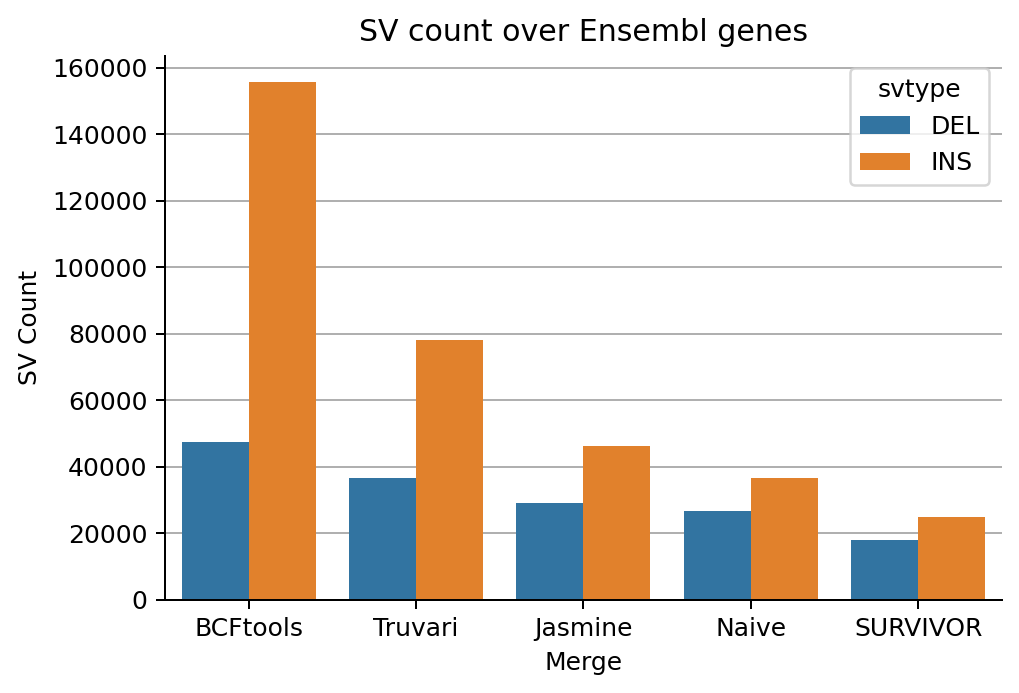

In [117]:
data = pd.read_csv("med_genes/merge_gene_hits.txt", sep='\t')
plt.figure(dpi=180)
m_order = ["BCFtools", "Truvari", "Jasmine", "Naive", "SURVIVOR"]
p = sb.barplot(data=data, x="merge", y="count", hue="svtype", order=m_order)
p.set(title="SV count over Ensembl genes", xlabel="Merge", ylabel="SV Count")
sb.despine()
plt.grid(which='major', axis='y')
p.set_axisbelow(True)

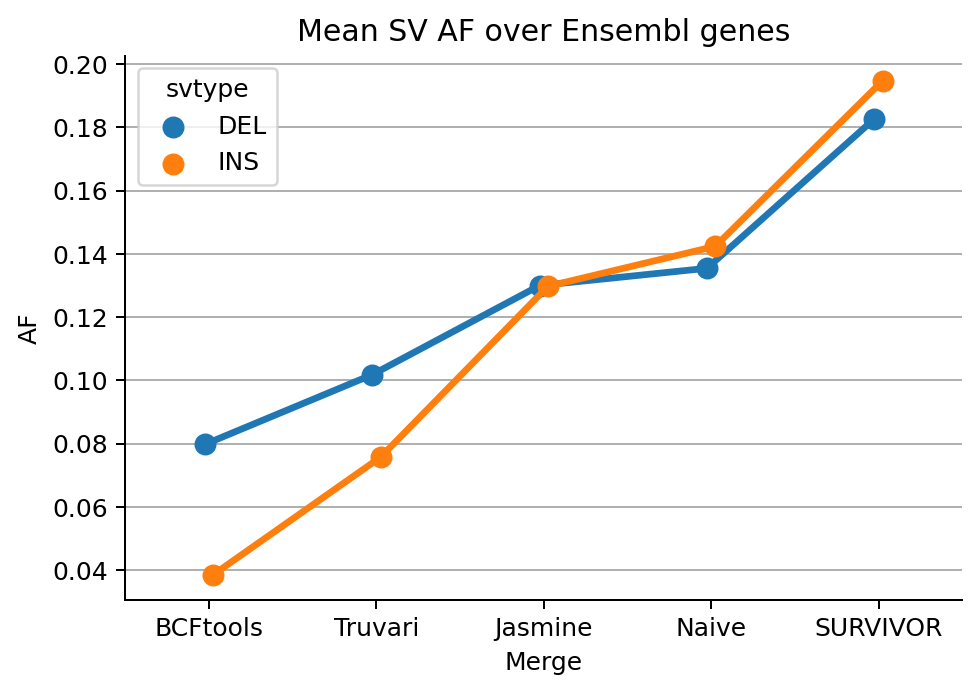

In [118]:
data = joblib.load("med_genes/af_dists.jl")
plt.figure(dpi=180)
m_order = ["BCFtools", "Truvari", "Jasmine", "Naive", "SURVIVOR"]
import numpy as np
p = sb.pointplot(data=data, x="merge", y="AF", hue="svtype", ci=0, 
                 estimator=np.mean, hue_order=["DEL", "INS"], order=m_order, dodge=True)
p.set(title="Mean SV AF over Ensembl genes", xlabel="Merge")
sb.despine()
plt.grid(which='major', axis='y')
p.set_axisbelow(True)

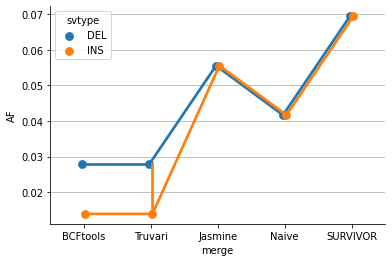

In [79]:
p = sb.pointplot(data=data, x="merge", y="AF", hue="svtype", ci=95, estimator=np.median, hue_order=["DEL", "INS"], order=m_order, dodge=True)
sb.despine()
plt.grid(which='major', axis='y')
p.set_axisbelow(True)

# Table 1

In [106]:
import glob
import json
import truvari

fns = glob.glob("med_genes/cmrg_bench/*/summary.txt")
gt_map = {'(1, 1)': "HOM", '(1, 0)': 'HET', '(0, 1)': 'HET'}
parts = []
for i in fns:
    merge = i.split('/')[-2].split('_')[0]
    d = json.load(open(i))
    x = pd.DataFrame(d['gt_matrix'])
    c = x.columns.map(gt_map)
    x.columns = c
    x.set_index(x.index.map(gt_map), inplace=True)
    del(d['gt_matrix'])
    d['gt_concordance'] = (x.loc["HET"]["HET"].sum().sum() + x.loc['HOM']['HOM']) / x.sum().sum()
    d['merge'] = merge
    parts.append(d)
parts = pd.DataFrame(parts)
parts['merge'] = parts['merge'].map({'truvari':"Truvari", 
                                     "survivor":"SURVIVOR", 
                                     "naive":"Naive", 
                                     "jasmine":"Jasmine",
                                    "exact":"BCFtools"})
parts.set_index('merge', inplace=True)

In [109]:
parts.loc[["BCFtools", "Truvari", "Jasmine", "Naive", "SURVIVOR"]][["TP-base", "FP", "FN", "precision", "recall", "f1", "base cnt", "call cnt", "gt_concordance"]]

,TP-base,FP,FN,precision,recall,f1,base cnt,call cnt,gt_concordance
merge,,,,,,,,,
BCFtools,201,5,15,0.975728,0.930556,0.952607,216,206,0.950249
Truvari,200,5,16,0.975610,0.925926,0.950119,216,205,0.950000
Jasmine,196,10,20,0.951456,0.907407,0.928910,216,206,0.948980
Naive,171,22,45,0.886010,0.791667,0.836186,216,193,0.947368
SURVIVOR,160,28,56,0.851064,0.740741,0.792079,216,188,0.956250
